In [1]:
import networkx as nx
from mypulp import Model, quicksum, GRB
import matplotlib.pyplot as plt
import random

In [3]:
# Steiner木問題
m, n = 5,5
lb, ub = 1, 20
random.seed(1)
G = nx.grid_2d_graph(m,n)

pos = {(i, j): (i, j) for (i,j) in G.nodes()}
for (i,j) in G.edges():
    G[i][j]["weight"] = random.randint(lb, ub)


# Terminalというものが入ってくる
Terminal = [(0,0), (m-1, 0), (0, n-1), (m-1, n-1)]
root = Terminal[0]
print(root)

(0, 0)


In [4]:
model = Model()
x, f = {}, {}
for (i, j) in G.edges():
    x[i,j] = model.addVar(vtype="B", name=f"x[{i}, {j}]")
    for k in Terminal[1:]:
        f[i,j,k] = model.addVar(vtype="C", name=f"x[{i}, {j} {k}]")
        f[j,i,k] = model.addVar(vtype="C", name=f"x[{j}, {i} {k}]")

# model.update()

for k in Terminal[1:]:
    for i in G.nodes():
        if i == root:
            model.addConstr(
                quicksum(f[i,j,k] for j in G[i]) - quicksum(f[j, i, k] for j in G[i]) == 1
            )
        elif i == k:
            model.addConstr(
                quicksum(f[i,j,k] for j in G[i]) - quicksum(f[j,i,k] for j in G[i]) == -1
            )
        else:
            model.addConstr(
                quicksum(f[i,j,k] for j in G[i]) - quicksum(f[j,i,k] for j in G[i]) == 0
            )

for (i,j) in G.edges():
    for k in Terminal[1:]:
        model.addConstr(f[i,j,k] + f[j,i,k] <= x[i,j])

model.setObjective(
    quicksum(G[i][j]["weight"] * x[i,j] for (i,j) in G.edges()), GRB.MINIMIZE
)

model.optimize()
edges = []
print(model.ObjVal)

for (i,j) in G.edges():
    if x[i,j].X  > 0.01:
        edges.append((i,j))

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/penguin/.conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/a0dfb91ce5af42bf8a2ebe9b31d8ff83-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/a0dfb91ce5af42bf8a2ebe9b31d8ff83-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 200 COLUMNS
At line 1161 RHS
At line 1357 BOUNDS
At line 1638 ENDATA
Problem MODEL has 195 rows, 280 columns and 840 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 73 - 0.00 seconds
Cgl0004I processed model has 195 rows, 280 columns (40 integer (40 of which binary)) and 840 elements
Cbc0038I Initial state - 10 integers unsatisfied sum - 5
Cbc0038I Pass   1: suminf.    5.00000 (10) obj. 95.5 iterations 62
Cbc0038I Solution found of 146
Cbc0038I Relaxing continuous gives 146
Cbc0038I Before mini branch and bound, 25 integers at 

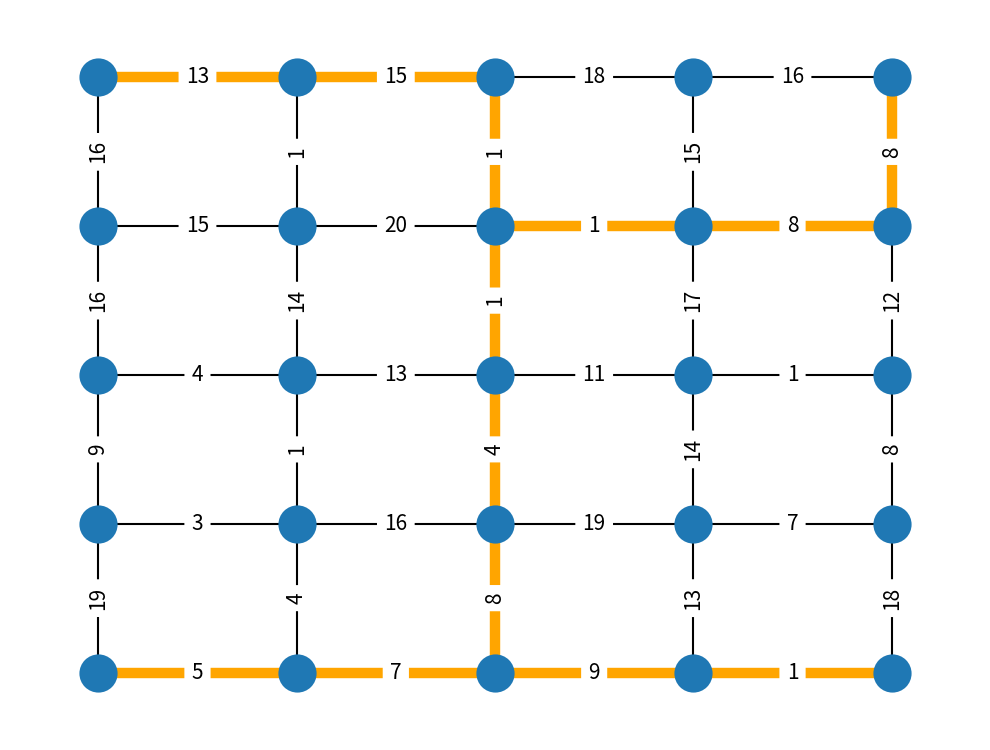

In [6]:
plt.figure()
nx.draw(G, pos=pos, node_size=100)
edge_labels = {}
for (i, j) in G.edges():
    edge_labels[i, j] = f"{ G[i][j]['weight'] }"

nx.draw(G, pos=pos, width=5, edgelist=edges, edge_color="orange")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

In [7]:
from networkx.algorithms.approximation.steinertree import steiner_tree
steiner = steiner_tree(G, terminal_nodes=Terminal)

In [8]:
total = 0
for (i, j) in steiner.edges():
    total += G[i][j]["weight"]
print(total)

85


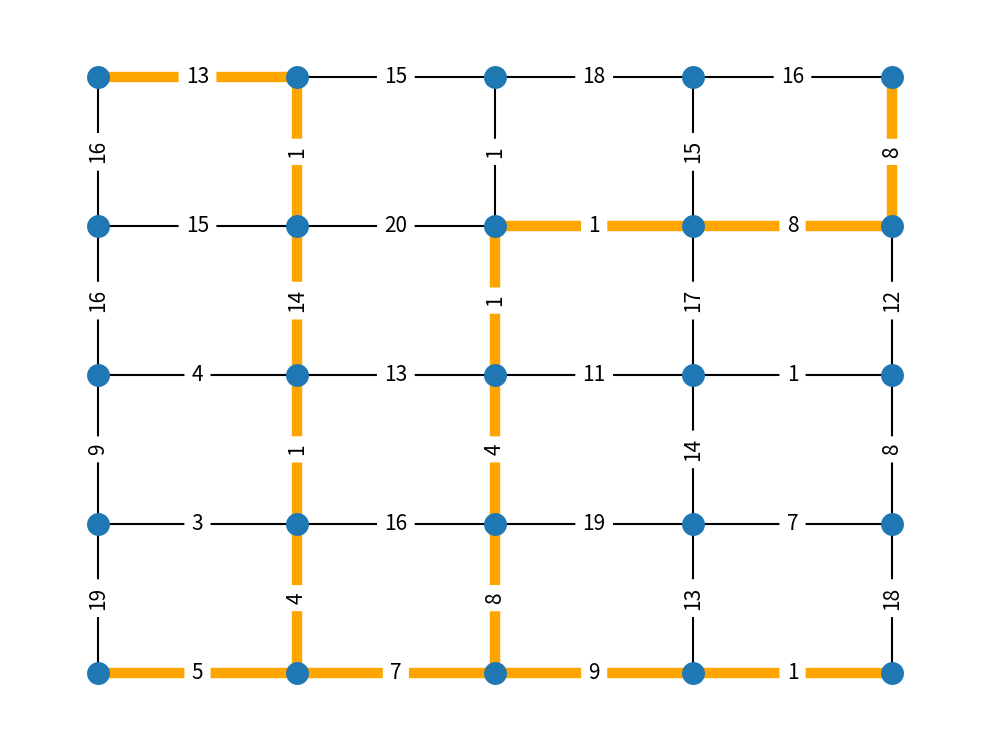

In [10]:
plt.figure()
nx.draw(G, pos=pos, with_labels=False, node_size=100)

nx.draw(G, pos=pos, width=5, edgelist=steiner.edges(), edge_color="orange", node_size=0)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

In [11]:
m, n = 5, 5
lb, ub = 1, 20
plb, pub = 1, 20
root = (0, 0)
G = nx.grid_2d_graph(m, n)
pos = {(i, j): (i, j) for (i, j) in G.nodes()}
for (i, j) in G.edges():
    G[i][j]["weight"] = random.randint(lb, ub)
for i in G.nodes():
    if i != root:
        G.nodes[i]["prize"] = random.randint(plb, pub)
D = G.to_directed()

In [12]:
model = Model()
x, y, f = {}, {}, {}
for (i, j) in D.edges():
    x[i, j] = model.addVar(vtype="B", name=f"x[{i},{j}]")
    for k in D.nodes():
        if k != root:
            f[i, j, k] = model.addVar(vtype="C", name=f"f[{i},{j},{k}]")
for i in D.nodes():
    if i != root:
        y[i] = model.addVar(vtype="B", name=f"y[{i}]")
model.update()
for i in D.nodes():
    if i != root:
        model.addConstr(quicksum(x[j, i] for j in D[i]) == y[i])
for k in D.nodes():
    if k == root:
        continue
    for i in D.nodes():
        if i == root:
            model.addConstr(
                quicksum(f[i, j, k] for j in D[i]) - quicksum(f[j, i, k] for j in D[i])
                == y[k]
            )
        elif i == k:
            model.addConstr(
                quicksum(f[i, j, k] for j in D[i]) - quicksum(f[j, i, k] for j in D[i])
                == -y[k]
            )
        else:
            model.addConstr(
                quicksum(f[i, j, k] for j in D[i]) - quicksum(f[j, i, k] for j in D[i])
                == 0
            )
for (i, j) in D.edges():
    for k in D.nodes:
        if k != root:
            model.addConstr(f[i, j, k] <= x[i, j])
model.setObjective(
    quicksum(D.nodes[i]["prize"] * y[i] for i in D.nodes() if i != root)
    - quicksum(D[i][j]["weight"] * x[i, j] for (i, j) in D.edges()),
    GRB.MAXIMIZE,
)
model.optimize()
edges = []
print(model.ObjVal)
for (i, j) in D.edges():
    if x[i, j].X > 0.01:
        edges.append((i, j))

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/penguin/.conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/f41318b6b7214080b74563e3da0017cd-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/f41318b6b7214080b74563e3da0017cd-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2549 COLUMNS
At line 10692 RHS
At line 13237 BOUNDS
At line 15262 ENDATA
Problem MODEL has 2544 rows, 2024 columns and 7830 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 93 - 0.07 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 0 strengthened rows, 6 substitutions
Cgl0004I processed model has 2538 rows, 2018 columns (104 integer (104 of which binary)) and 7818 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -93
Cbc0038I Relaxing continuous gives -93
Cbc0038I Before mini branch and

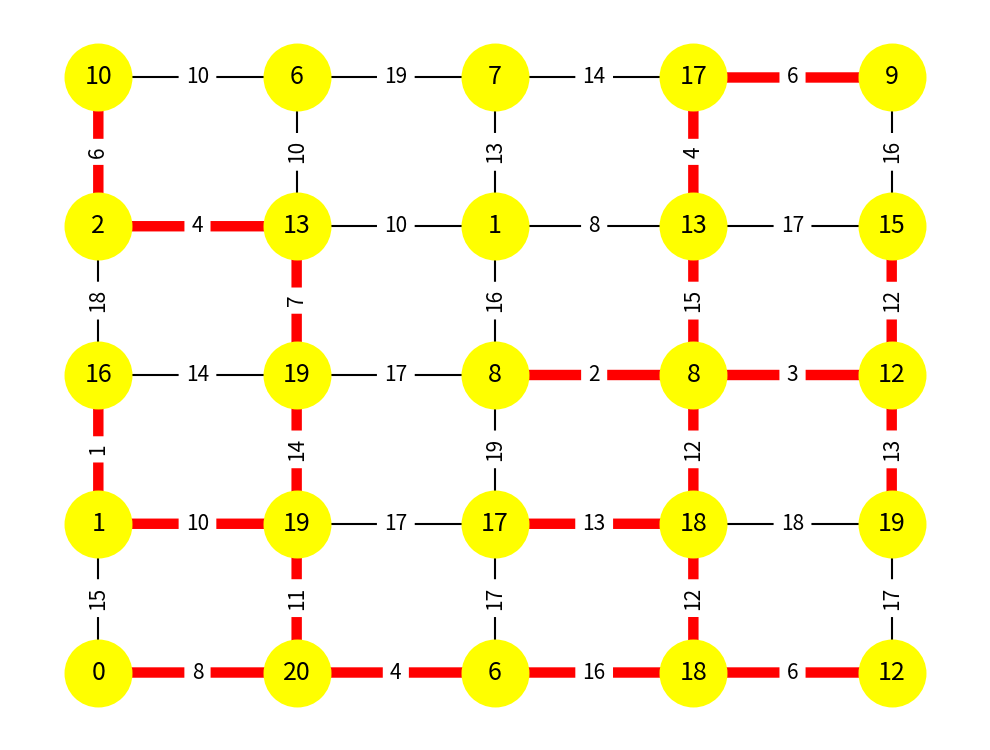

In [14]:
plt.figure()
nx.draw(G, pos=pos, with_labels=False, node_size=1000, node_color="yellow")
edge_labels = {}
for (i, j) in G.edges():
    edge_labels[i, j] = f"{ G[i][j]['weight'] }"
node_labels = {}
G.nodes[root]["prize"] = 0
for i in G.nodes():
    node_labels[i] = G.nodes[i]["prize"]
nx.draw_networkx_labels(G, pos, labels=node_labels)

nx.draw(D, pos=pos, width=5, edgelist=edges, edge_color="red", node_size=0)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()